In [0]:
import pickle
import os
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import math

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def unpickle(file):
    '''unpickles the data into a dictionary'''
    with open(file, 'rb') as foo:
        dictionary = pickle.load(foo, encoding='latin1')
    return dictionary

def transform_batch(dictionary):
    '''Transforms the data into arrays and labels'''
    X = dictionary['data']
    Y = dictionary['labels']
    X = X.reshape(10000,3072)
    Y = np.array(Y)
    return X, Y

def load_all(PATH):
    '''loads in all the data_batch(1-5) and the test_batch'''
    filenames = os.listdir(PATH)
    filenames = [i for i in filenames if 'data_batch' in i]

    data, labels = [], []
    for i in range(1,6):
        dict_ = unpickle(PATH+"/data_batch_"+str(i))
        X_, Y_ = transform_batch(dict_)
        data.append(X_)
        labels.append(Y_)
    dict_ = unpickle(PATH+"/test_batch")
    X_, Y_ = transform_batch(dict_)
    data.append(X_)
    labels.append(Y_)

    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels
    


def get_shape_32x32(data):
    data = data.reshape(len(data),3,32,32)
    print(data.shape)
    return data


In [0]:
def normalize(data):
    global mean_, std_
    data = data.astype('float32')
    data /= 255 
    mean_ = list(data.mean(axis=(0,2,3)))
    std_ = list(data.std(axis=(0,2,3)))
    data = torch.from_numpy(data)
    preprocess = transforms.Compose([transforms.Normalize(mean=mean_, std=std_)])
    
    for i in range(0,len(data)):
        data[i] = preprocess(data[i])

    return data

In [5]:
PATH = "/content"
data, labels = load_all(PATH)
data = get_shape_32x32(data)
Counter(labels)
data = normalize(data)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(60000, 3, 32, 32)


In [6]:
def get_100_from_each(labels):
    #selects 1000 indeces from labels, 100/class
    subset_ids = []

    for i in range(0,10):
        class_ids_ = np.where(labels == i) #show id's of labels where class is 'i'
        class_ids_subset_ = np.random.choice(class_ids_[0],size=100, replace=False,p=None) #select 100 ids from a class
        subset_ids.extend(class_ids_subset_)
    return subset_ids

indeces = get_100_from_each(labels) #indexes 
print(len(indeces))

1000


In [7]:
train_data, train_labels, test_data, test_labels = [], [], [], []

for i in range(0,60000):
    if i in indeces:
        train_data.append(data[i])
        train_labels.append(labels[i])
    else:
        test_data.append(data[i])
        test_labels.append(labels[i])
print(len(train_data))

1000


In [8]:
Counter(train_labels)

Counter({0: 100,
         1: 100,
         2: 100,
         3: 100,
         4: 100,
         5: 100,
         6: 100,
         7: 100,
         8: 100,
         9: 100})

In [0]:
X_train = torch.stack(train_data)
X_test = torch.stack(test_data)
y_train = torch.LongTensor(train_labels)
y_test = torch.LongTensor(test_labels)

train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=32)
test_dataset = TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset,batch_size=32)

BATCH=32

In [0]:
__all__ = ['MobileNetV2', 'mobilenet_v2']


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        
        ## CIFAR10
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 1], # Stride 2 -> 1 for CIFAR-10
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        ## END

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        
        # CIFAR10: stride 2 -> 1
        features = [ConvBNReLU(3, input_channel, stride=1)]
        # END
        
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

   
    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x1 = self.classifier(x)
        x2 = torch.ones((x.shape))
        x2=x2.cuda()
        return x1, x2


def mobilenet_v2(pretrained=False, progress=True, device='cpu', **kwargs):
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        try:
            from torch.hub import load_state_dict_from_url
        except ImportError:
            from torch.utils.model_zoo import load_url as load_state_dict_from_url
        state_dict = load_state_dict_from_url(
            'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
        model.load_state_dict(state_dict)
    return model

In [0]:
net = mobilenet_v2(pretrained=False) #right now can't use true
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=4e-5)


In [12]:

losses = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    run_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels=labels.cuda()


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, outputs2 = net(inputs)

        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        run_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    epoch_loss = run_loss/len(train_dataloader)
    losses.append(epoch_loss)

print('Finished Training')

Finished Training


[2.77437861263752, 2.1825511157512665, 1.9913193620741367, 1.9313098825514317, 1.8896504119038582, 1.8122431375086308, 1.7189403213560581, 1.6582192946225405, 1.6777787990868092, 1.609028048813343]


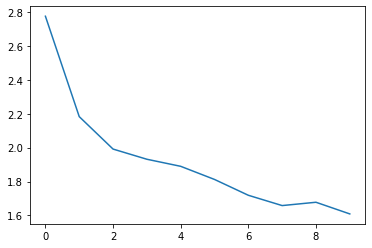

In [13]:
print(losses)
import matplotlib.pyplot as plt

plt.plot(losses)

In [14]:
#testing on the test set

correct = 0
total = 0
with torch.no_grad():
    cnt=0
    for data in test_dataloader:
        cnt+=1
        images, labels = data
        images = images.cuda() 
        labels = labels.cuda() 

        outputs,outputs2 = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 59000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 59000 test images: 31 %


In [17]:
#which lables were good
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.cuda() 
        labels = labels.cuda() 

        outputs,outputs2 = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 42 %
Accuracy of  bird : 28 %
Accuracy of   cat :  9 %
Accuracy of  deer :  4 %
Accuracy of   dog : 37 %
Accuracy of  frog : 42 %
Accuracy of horse : 40 %
Accuracy of  ship : 22 %
Accuracy of truck : 31 %


In [0]:
PATH='modified_model_1k_2'

torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion
            }, PATH)